In [124]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [125]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import PIL
import time
import functools

In [127]:
import tensorflow as tf  # Import the TensorFlow library for deep learning

# Function to convert a TensorFlow tensor to an image using PIL library
def convert_tensor_to_image(tensor):
    # Scaling the tensor values to convert to image pixel values
    scaled_tensor = tensor * 255
    # Converting the tensor to a NumPy array with unsigned 8-bit integers
    numpy_array = np.array(scaled_tensor, dtype=np.uint8)
    # Checking for dimensions and adjusting accordingly
    if np.ndim(numpy_array) > 3:
        assert numpy_array.shape[0] == 1
        numpy_array = numpy_array[0]
    # Converting the NumPy array to a PIL image
    image = PIL.Image.fromarray(numpy_array)
    return image

# Function to load an image from a file path
def load_img(path_to_img):
    # Defining the maximum dimension for the image
    max_dim = 512
    # Reading the image file using TensorFlow's I/O module
    image = tf.io.read_file(path_to_img)
    # Decoding the image and converting it to floating point representation
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Calculating the shape of the image
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    # Calculating the scaling factor based on the maximum dimension
    scale = max_dim / long_dim
    # Computing the new shape and resizing the image accordingly
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    # Adding a batch dimension to the image
    image = image[tf.newaxis, :]
    return image

# Function to display an image using Matplotlib
def imshow(image, title=None):
    # Checking if the image has a batch dimension and removing it if present
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    # Displaying the image using Matplotlib
    plt.imshow(image)

    # Setting a title for the image if provided
    if title:
        plt.title(title)

# Function to extract VGG model layers for style and content representation
def vgg_layers(layer_names):
    # Loading a pre-trained VGG19 model with ImageNet weights
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # Setting the model to be non-trainable
    vgg_model.trainable = False
    # Initializing an empty list to store intermediate layer outputs
    outputs = []
    # Looping through each layer name to extract layer outputs
    for name in layer_names:
        # Getting the specific layer by its name from the VGG model
        layer = vgg_model.get_layer(name)
        # Retrieving the output tensor of the layer
        output = layer.output
        # Appending the output tensor to the list of outputs
        outputs.append(output)
    # Creating a new model that takes the VGG input and outputs the selected layers' outputs
    model = tf.keras.Model(inputs=[vgg_model.input], outputs=outputs)
    return model

# Function to compute the Gram matrix for a given input tensor
def gram_matrix(input_tensor):
    # Computing the Gram matrix using Einstein summation
    result = tf.linalg.einsum('bijc, bijd -> bcd', input_tensor, input_tensor)
    # Getting the shape of the input tensor
    input_shape = tf.shape(input_tensor)
    # Calculating the number of locations (height * width)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    # Normalizing the Gram matrix by the number of locations
    gram = result / num_locations
    return gram

# Class to create a custom model that computes style and content representations
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        # Creating a VGG model for both style and content layers
        self.vgg_model = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg_model.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        # Scaling the input image values to match the expected range
        inputs = inputs * 255.0
        # Preprocessing the input image for the VGG network
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        # Forward pass through the VGG model to get outputs
        outputs = self.vgg_model(preprocessed_input)
        # Separating the outputs into style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        # Computing Gram matrices for style representations
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        # Creating dictionaries for content and style representations
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        # Returning content and style representations in a dictionary
        return {'content': content_dict, 'style': style_dict}

# Function to compute style and content losses and combine them
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    # Calculating style loss by comparing style representations
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers
    # Calculating content loss by comparing content representations
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    # Combining style and content losses to get the total loss
    loss = style_loss + content_loss
    return loss


In [128]:
@tf.function()
def model_training_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(vgg_model(image))

In [129]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

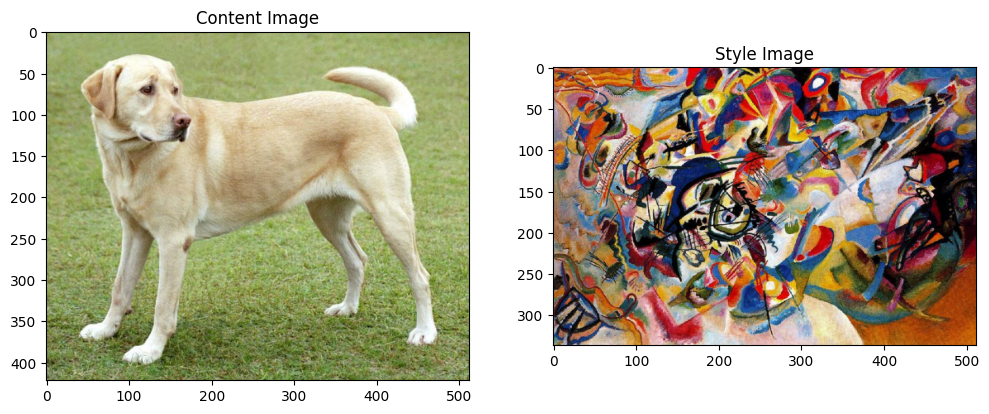

In [130]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

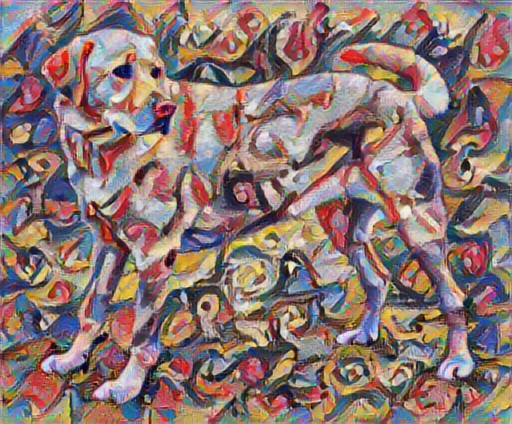

In [131]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
new_stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
convert_tensor_to_image(new_stylized_image)

In [132]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg_model = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg_model(x)

In [133]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317107),
 ('golden_retriever', 0.23665293),
 ('kuvasz', 0.03635751),
 ('Chesapeake_Bay_retriever', 0.024182767),
 ('Greater_Swiss_Mountain_dog', 0.018646102)]

In [134]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [136]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))


In [138]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [139]:
image = tf.Variable(content_image)

In [140]:
def vgg_model(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [141]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [142]:
style_weight=1e-2
content_weight=1e4

In [143]:
@tf.function()
def model_training_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(vgg_model(image))

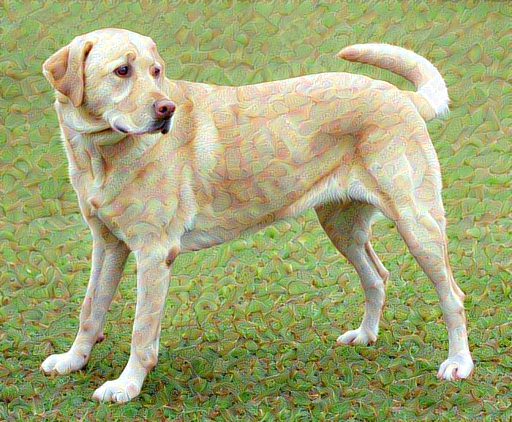

In [144]:
model_training_step(image)
model_training_step(image)
model_training_step(image)
convert_tensor_to_image(image)

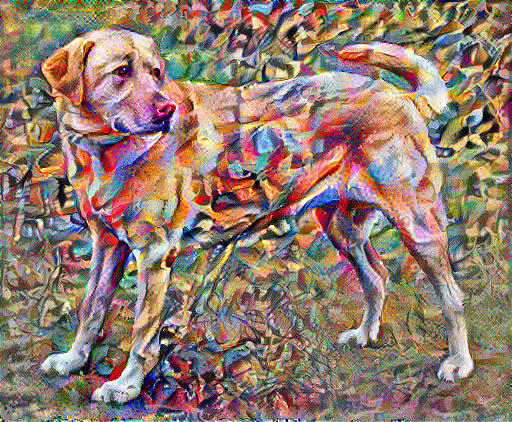

Train step: 1000
Total time: 75.7


In [145]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    model_training_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(convert_tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [146]:
file_name = 'stylized-image.png'
convert_tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>